### Spotify song recommender

In [7]:
#importing necessary libraries
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D
from bs4 import BeautifulSoup
import requests
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [8]:
secrets_file = open("secrets.txt","r") # exact file name or the path of the file where it comes from.
string = secrets_file.read()


In [9]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        print(line.split(':'))# gives a list 
        secrets_dict[line.split(':')[0]]=line.split(':')[1] 
        


['cid', '3ff19e99b13f4376a0e01e3a56ee6d40']
['csecret', '9c17a9a9f8f84b0bb8967f84bc4dab7c']


In [10]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))


In [12]:
# Reusable functions
def get_name_artists_from_track(track):
    return [(track["name"],artist["name"], track["uri"]) for artist in track["artists"] or []]

def flatten(input_list):
    return [item for sublist in input_list for item in sublist]

#first we need to get a list of individual tracks from the playlist
def get_name_artist_from_playlist_item(playlist_item):
    return get_name_artists_from_track(playlist_item['track'])

def get_name_artists_from_playlist_items(playlist_items):
    return flatten(list(map(get_name_artist_from_playlist_item,playlist_items)))

In [13]:
# Get all the tracks from a playlist by applying pagination
from random import randint
from time import sleep

def get_playlist_items(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    items = results['items']
    while results['next']!=None:
        print('Fetching {0} page out of {1}'.format(results['offset'], results['total']))
        results = sp.next(results)
        items = items + results['items']
        sleep(randint(1,3))
    print('Done!')
    return items

In [14]:
# this will take at least around num_songs_in_playlist * (avg_sleep_time + processing_time) = (number of songs/100) * (2+0.1) = 110 seconds

playlists = ['2HTcOvM2Yq1qNRsGIsW0nW','1HuLhcQu2aZ6VQePfObpuJ','5TQjirT55qqKCxDfpoSCEX','1TM3rECdFTc0R0tgiIf0oW','7sKSwkokJvWgmDMmFg7UXF','37i9dQZF1DX7BXvxNJkwzB','1iKrRpeXJbcxIDoixPYHXj','1OfeGWEHudCL9mtqoR6Os8','5QNJOLGrpEEI6J7sas5cPR', '0xiiwsdEmtKWX8v8nXVefk']
all_items = []
for playlist in playlists:
    all_items.extend(get_playlist_items(playlist))
len(all_items)

Fetching 0 page out of 8080
Fetching 100 page out of 8080
Fetching 200 page out of 8080
Fetching 300 page out of 8080
Fetching 400 page out of 8080
Fetching 500 page out of 8080
Fetching 600 page out of 8080
Fetching 700 page out of 8080
Fetching 800 page out of 8080
Fetching 900 page out of 8080
Fetching 1000 page out of 8080
Fetching 1100 page out of 8080
Fetching 1200 page out of 8080
Fetching 1300 page out of 8080
Fetching 1400 page out of 8080
Fetching 1500 page out of 8080
Fetching 1600 page out of 8080
Fetching 1700 page out of 8080
Fetching 1800 page out of 8080
Fetching 1900 page out of 8080
Fetching 2000 page out of 8080
Fetching 2100 page out of 8080
Fetching 2200 page out of 8080
Fetching 2300 page out of 8080
Fetching 2400 page out of 8080
Fetching 2500 page out of 8080
Fetching 2600 page out of 8080
Fetching 2700 page out of 8080
Fetching 2800 page out of 8080
Fetching 2900 page out of 8080
Fetching 3000 page out of 8080
Fetching 3100 page out of 8080
Fetching 3200 page o

26403

In [16]:
#all_items

In [17]:
i = 0
for item in all_items:
    if(item['track'] is None):
        print(i)
        all_items.remove(item)
        i = i + 1


In [18]:
track_data = get_name_artists_from_playlist_items(all_items)
track_data[0:10]

[("Hey Leroy, Your Mama's Calling You",
  'Jimmy Castor',
  'spotify:track:6DPdkuilLYzkZIGr53HsrG'),
 ('Bang, Bang', 'Jimmy Castor', 'spotify:track:6puSkh7Unbn3avNFvZMZz1'),
 ('All I Ever Wanted',
  'The Human League',
  'spotify:track:33g1XVNgo3lbDLeRiRQ0TL'),
 ('Big Time Sensuality - The Fluke Minimix',
  'Björk',
  'spotify:track:4Q8b1l8daZE9ALzkd6kKzL'),
 ('Big Time Sensuality - The Fluke Minimix',
  'Fluke',
  'spotify:track:4Q8b1l8daZE9ALzkd6kKzL'),
 ('Fata Morgana - Original Mix',
  'Der Dritte Raum',
  'spotify:track:1yzgJNsnTGZacmsrcvZL4V'),
 ('Bad Reputation',
  'Joan Jett & the Blackhearts',
  'spotify:track:5M5ySjWYS4s6hi2pEvEwb5'),
 ('My Window', 'The Residents', 'spotify:track:61t7MU96q1DWE8eXBsUGua'),
 ('Winchester Cathedral',
  'Jimmy Castor',
  'spotify:track:5fPsQzd4GMMPt7qePOxnAX'),
 ('Donna', 'Rubblebucket', 'spotify:track:5UuVuVCEag2VYp8PdWB2eB')]

In [19]:


# Converted track name, artist name and uri from the above to dataframe for merging it with audo features

track_df = pd.DataFrame(track_data, columns = ['track_name', 'artist_name', 'uri'])
print(track_df.shape)
track_df.head(10)

(33138, 3)


,track_name,artist_name,uri
0,"Hey Leroy, Your Mama's Calling You",Jimmy Castor,spotify:track:6DPdkuilLYzkZIGr53HsrG
1,"Bang, Bang",Jimmy Castor,spotify:track:6puSkh7Unbn3avNFvZMZz1
2,All I Ever Wanted,The Human League,spotify:track:33g1XVNgo3lbDLeRiRQ0TL
3,Big Time Sensuality - The Fluke Minimix,Björk,spotify:track:4Q8b1l8daZE9ALzkd6kKzL
4,Big Time Sensuality - The Fluke Minimix,Fluke,spotify:track:4Q8b1l8daZE9ALzkd6kKzL
5,Fata Morgana - Original Mix,Der Dritte Raum,spotify:track:1yzgJNsnTGZacmsrcvZL4V
6,Bad Reputation,Joan Jett & the Blackhearts,spotify:track:5M5ySjWYS4s6hi2pEvEwb5
7,My Window,The Residents,spotify:track:61t7MU96q1DWE8eXBsUGua
8,Winchester Cathedral,Jimmy Castor,spotify:track:5fPsQzd4GMMPt7qePOxnAX
9,Donna,Rubblebucket,spotify:track:5UuVuVCEag2VYp8PdWB2eB


In [20]:
all_items[0]['track']['uri']

'spotify:track:6DPdkuilLYzkZIGr53HsrG'

In [23]:

def get_track_uri(item):
    return item['track']['uri']

def get_track_uris(items):
    return list(map(get_track_uri, items))

track_uris = get_track_uris(all_items)
print(len(track_uris))

# Filter out non track uris (spotify:local:songname) as they cause error during fetching audio features
track_uris = list(filter(lambda x: 'spotify:track:' in x, track_uris))
print(len(track_uris))

# took from the stackoverflow "https://stackoverflow.com/questions/312443/how-do-i-split-a-list-into-equally-sized-chunks"

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Split track_uris list in to chunks of 100 (sub list), so that I can use bulk audio_features request, instead of one by one
track_uris_batch = list(chunks(track_uris, 100))
#track_uris_batch[0:2]

26403
26000


In [26]:
# For all the tracks, get the audio features one by one and append it to a list
audio_features = []
for i, track_uri in enumerate(track_uris_batch):
    #print('Fetching audio feature for track number {0} from {1}'.format(i, len(track_uris_batch)))
    audio_feature = sp.audio_features(track_uri)
    audio_features.extend(audio_feature)
    sleep(randint(1,3))
print('Done')
#audio_features[0:50]

Done


In [27]:
# Convert audio features list (of dict) to a dataframe. Because we can merge it with the track name, artist name dataframe we have created above in the next step
audio_features_df = pd.DataFrame(audio_features)
audio_features_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.714,0.765,0,-9.380,1,0.0406,0.41000,0.508000,0.1190,0.9610,105.796,audio_features,6DPdkuilLYzkZIGr53HsrG,spotify:track:6DPdkuilLYzkZIGr53HsrG,https://api.spotify.com/v1/tracks/6DPdkuilLYzk...,https://api.spotify.com/v1/audio-analysis/6DPd...,148440,4
1,0.655,0.878,3,-9.544,1,0.0312,0.83300,0.000402,0.0888,0.9360,129.957,audio_features,6puSkh7Unbn3avNFvZMZz1,spotify:track:6puSkh7Unbn3avNFvZMZz1,https://api.spotify.com/v1/tracks/6puSkh7Unbn3...,https://api.spotify.com/v1/audio-analysis/6puS...,188160,4
2,0.649,0.789,0,-9.466,1,0.0264,0.00441,0.000002,0.0859,0.9310,129.549,audio_features,33g1XVNgo3lbDLeRiRQ0TL,spotify:track:33g1XVNgo3lbDLeRiRQ0TL,https://api.spotify.com/v1/tracks/33g1XVNgo3lb...,https://api.spotify.com/v1/audio-analysis/33g1...,234333,4
3,0.644,0.785,8,-8.642,1,0.0284,0.00032,0.116000,0.0451,0.6680,116.938,audio_features,4Q8b1l8daZE9ALzkd6kKzL,spotify:track:4Q8b1l8daZE9ALzkd6kKzL,https://api.spotify.com/v1/tracks/4Q8b1l8daZE9...,https://api.spotify.com/v1/audio-analysis/4Q8b...,293840,4
4,0.810,0.658,2,-9.676,1,0.0463,0.00348,0.922000,0.0744,0.7430,126.009,audio_features,1yzgJNsnTGZacmsrcvZL4V,spotify:track:1yzgJNsnTGZacmsrcvZL4V,https://api.spotify.com/v1/tracks/1yzgJNsnTGZa...,https://api.spotify.com/v1/audio-analysis/1yzg...,339524,4
5,0.385,0.975,6,-4.099,1,0.1920,0.00197,0.016700,0.0602,0.8210,204.397,audio_features,5M5ySjWYS4s6hi2pEvEwb5,spotify:track:5M5ySjWYS4s6hi2pEvEwb5,https://api.spotify.com/v1/tracks/5M5ySjWYS4s6...,https://api.spotify.com/v1/audio-analysis/5M5y...,170841,4
6,0.205,0.246,8,-16.175,1,0.0313,0.24500,0.602000,0.1110,0.0343,97.059,audio_features,61t7MU96q1DWE8eXBsUGua,spotify:track:61t7MU96q1DWE8eXBsUGua,https://api.spotify.com/v1/tracks/61t7MU96q1DW...,https://api.spotify.com/v1/audio-analysis/61t7...,320960,3
7,0.756,0.803,2,-9.508,0,0.0956,0.42700,0.072400,0.0824,0.8780,136.568,audio_features,5fPsQzd4GMMPt7qePOxnAX,spotify:track:5fPsQzd4GMMPt7qePOxnAX,https://api.spotify.com/v1/tracks/5fPsQzd4GMMP...,https://api.spotify.com/v1/audio-analysis/5fPs...,163800,4
8,0.572,0.942,11,-3.660,0,0.0448,0.00280,0.055900,0.3500,0.8140,112.014,audio_features,5UuVuVCEag2VYp8PdWB2eB,spotify:track:5UuVuVCEag2VYp8PdWB2eB,https://api.spotify.com/v1/tracks/5UuVuVCEag2V...,https://api.spotify.com/v1/audio-analysis/5UuV...,213813,4
9,0.712,0.680,1,-8.132,1,0.0966,0.13500,0.000000,0.6290,0.5270,99.074,audio_features,43ievcG8mUfVBVn5OJkTrC,spotify:track:43ievcG8mUfVBVn5OJkTrC,https://api.spotify.com/v1/tracks/43ievcG8mUfV...,https://api.spotify.com/v1/audio-analysis/43ie...,243373,4


In [29]:
# Now I am merging the original dataframe with audio features df. The common column between these two DF is uri, so audio features will be duplicated for every track in the original dataframe
df = pd.merge(track_df, audio_features_df, on = 'uri')
print(df.shape)
df.sample(10)

(34105, 20)


,track_name,artist_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
11028,Forty Six & 2,TOOL,spotify:track:6AioOohg4bQZFA4jIYQQ2r,0.375,0.682,0,-6.898,0,0.0364,0.001520,0.598000,0.0897,0.396,159.230,audio_features,6AioOohg4bQZFA4jIYQQ2r,https://api.spotify.com/v1/tracks/6AioOohg4bQZ...,https://api.spotify.com/v1/audio-analysis/6Aio...,363067,4
29169,Order,Southside,spotify:track:04iHyjuODvU57m4c5MdFv5,0.888,0.489,9,-8.243,1,0.2060,0.033900,0.000000,0.0704,0.191,139.069,audio_features,04iHyjuODvU57m4c5MdFv5,https://api.spotify.com/v1/tracks/04iHyjuODvU5...,https://api.spotify.com/v1/audio-analysis/04iH...,183532,4
28599,Oprah’s Bank Account (Lil Yachty & DaBaby feat...,DaBaby,spotify:track:7wsmIIm0xWmtP7TmACXkJn,0.836,0.617,0,-4.363,1,0.0534,0.170000,0.000000,0.3190,0.866,138.066,audio_features,7wsmIIm0xWmtP7TmACXkJn,https://api.spotify.com/v1/tracks/7wsmIIm0xWmt...,https://api.spotify.com/v1/audio-analysis/7wsm...,206702,4
18673,A Message to You Rudy - 2002 Remastered Version,The Specials,spotify:track:2EwEtZrsBpjLmwhe7GCGhs,0.906,0.450,0,-8.003,1,0.0627,0.149000,0.000232,0.1680,0.969,103.476,audio_features,2EwEtZrsBpjLmwhe7GCGhs,https://api.spotify.com/v1/tracks/2EwEtZrsBpjL...,https://api.spotify.com/v1/audio-analysis/2EwE...,172600,4
23362,Ill Mind of Hopsin 5,Hopsin,spotify:track:7dDLHlyZJBqEWSndlPWyCT,0.737,0.707,1,-11.113,1,0.4480,0.514000,0.000000,0.3930,0.561,98.121,audio_features,7dDLHlyZJBqEWSndlPWyCT,https://api.spotify.com/v1/tracks/7dDLHlyZJBqE...,https://api.spotify.com/v1/audio-analysis/7dDL...,289004,4
9873,Second Home By The Sea - Remastered 2007,Genesis,spotify:track:1Lm3370rECO2o7qiAUblbp,0.471,0.785,4,-8.211,0,0.0285,0.000118,0.537000,0.3870,0.441,102.034,audio_features,1Lm3370rECO2o7qiAUblbp,https://api.spotify.com/v1/tracks/1Lm3370rECO2...,https://api.spotify.com/v1/audio-analysis/1Lm3...,367400,4
30307,Bankroll,YoungBoy Never Broke Again,spotify:track:4mnRt6k3hlMTYAKnk71Mrm,0.869,0.683,7,-5.063,0,0.2070,0.219000,0.000000,0.0763,0.830,120.949,audio_features,4mnRt6k3hlMTYAKnk71Mrm,https://api.spotify.com/v1/tracks/4mnRt6k3hlMT...,https://api.spotify.com/v1/audio-analysis/4mnR...,167410,4
14037,m.A.A.d city,Kendrick Lamar,spotify:track:0nfQguNoAfKFjsQHr6qnxc,0.487,0.729,2,-6.815,1,0.2710,0.053800,0.000004,0.4400,0.217,91.048,audio_features,0nfQguNoAfKFjsQHr6qnxc,https://api.spotify.com/v1/tracks/0nfQguNoAfKF...,https://api.spotify.com/v1/audio-analysis/0nfQ...,350120,4
1486,Where Love Lives (Come On In) - Classic Mix,David Morales,spotify:track:0ilZMeXHPKDPjUc4Neu04f,0.708,0.566,11,-10.142,0,0.0362,0.000127,0.033800,0.2900,0.731,121.997,audio_features,0ilZMeXHPKDPjUc4Neu04f,https://api.spotify.com/v1/tracks/0ilZMeXHPKDP...,https://api.spotify.com/v1/audio-analysis/0ilZ...,416027,4
31741,Ave Maria,Mac Miller,spotify:track:7dZ3m1rCWupPB1H7gVpkdk,0.426,0.758,5,-4.674,0,0.2500,0.082200,0.000000,0.1910,0.654,170.450,audio_features,7dZ3m1rCWupPB1H7gVpkdk,https://api.spotify.com/v1/tracks/7dZ3m1rCWupP...,https://api.spotify.com/v1/audio-analysis/7dZ3...,175779,4


In [30]:
# Check for duplicates
df.duplicated().sum()

2002

In [31]:
# Drop duplicates
df = df.drop_duplicates()
df.shape

(32103, 20)

In [38]:
# Writing the above dataframe to a csv file, so that I don't have to hit Spotify API again, as it is really slow to get the songs again
df.to_csv('./csv_files/spotify-top-playlist-audio-features.csv', index = False)

In [40]:
import glob
import os

In [41]:
files = os.path.join(os.getcwd(), "csv_files", "spotify*.csv")
files


'/Users/ayeesha/ironhack/song-recommender/csv_files/spotify*.csv'

In [42]:
files = glob.glob(files)

In [43]:
files

['/Users/ayeesha/ironhack/song-recommender/csv_files/spotify-top-playlist-audio-features.csv']

In [44]:
df = pd.concat(map(pd.read_csv, files), ignore_index=True)

df_spotify = df.copy()

#display(df_spotify)


In [45]:
df_spotify.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32103 entries, 0 to 32102
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        32103 non-null  object 
 1   artist_name       32103 non-null  object 
 2   uri               32103 non-null  object 
 3   danceability      32103 non-null  float64
 4   energy            32103 non-null  float64
 5   key               32103 non-null  int64  
 6   loudness          32103 non-null  float64
 7   mode              32103 non-null  int64  
 8   speechiness       32103 non-null  float64
 9   acousticness      32103 non-null  float64
 10  instrumentalness  32103 non-null  float64
 11  liveness          32103 non-null  float64
 12  valence           32103 non-null  float64
 13  tempo             32103 non-null  float64
 14  type              32103 non-null  object 
 15  id                32103 non-null  object 
 16  track_href        32103 non-null  object

In [46]:
df_spotify = df_spotify.drop(["track_name","artist_name","uri","type","id","track_href","analysis_url", "mode", "time_signature"], axis = 1)


In [47]:
display(df_spotify.sample(5))
df_spotify.shape

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
31918,0.604,0.971,4,-5.403,0.0471,0.000713,0.000116,0.3360,0.663,140.052,177160
16964,0.416,0.955,9,-4.677,0.1020,0.000366,0.000000,0.0712,0.887,193.135,171067
16243,0.681,0.623,9,-10.322,0.0324,0.193000,0.000003,0.0873,0.812,99.482,226013
26823,0.749,0.470,10,-7.939,0.3780,0.821000,0.000108,0.1750,0.591,75.072,129785
23213,0.524,0.440,0,-11.710,0.1370,0.174000,0.000000,0.0982,0.314,121.113,322667


(32103, 11)

In [48]:
# Remove duplicates after dropping columns
print(df_spotify.duplicated().sum())

df_spotify = df_spotify.drop_duplicates()
df_spotify.shape

6954


(25149, 11)

In [49]:
print(df_spotify.isna().sum())
df_spotify = df_spotify.dropna()
df_spotify.shape

danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64


(25149, 11)

In [50]:
X=df_spotify


std_scaler = StandardScaler().fit(X)
X_prep = std_scaler.transform(X)

# Now, all features will have the same weight.
pd.DataFrame(X_prep,columns=X.columns).sample(10)



,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
1890,1.011107,-0.051214,1.026744,0.275221,-0.576663,-0.835322,-0.404782,-0.672745,0.700871,0.474424,2.844117
14507,1.919220,-0.946731,1.580844,-0.840309,1.988530,-0.318246,-0.436007,-0.521308,1.020477,-0.009300,-0.303999
5969,0.398269,0.873347,-0.081455,-0.219716,-0.526774,-0.344880,-0.436181,-1.014577,1.497915,-0.813439,0.285821
20332,-1.183965,-0.772468,1.580844,0.991313,0.473724,-0.801870,-0.436198,1.791087,1.008640,0.762804,-1.053805
16375,-0.693696,-1.377548,-0.358505,-1.794408,-0.663742,1.177027,-0.400986,-0.540159,-1.200987,0.089228,1.573055
16348,0.855112,-1.895495,0.195595,-1.446119,-0.581199,0.397050,-0.436180,-0.483606,0.523311,0.072212,-0.281577
940,0.927538,-1.367866,1.303794,-3.008689,-0.622017,-0.215518,-0.436203,-0.828580,1.714932,0.181407,-0.079995
16264,-0.431847,-2.108483,-1.466704,-2.449889,-0.677348,0.891669,-0.435616,-0.918437,-0.293462,0.131858,-0.858334
6710,-0.988972,-1.735754,-0.635554,-0.702531,-0.622017,0.400854,-0.396346,-0.853087,-1.811792,0.294383,4.392555
20807,1.261813,0.040758,-1.189654,0.256594,1.217521,-0.394342,-0.436188,0.980492,-0.317136,0.327274,0.208026


## choosing K

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

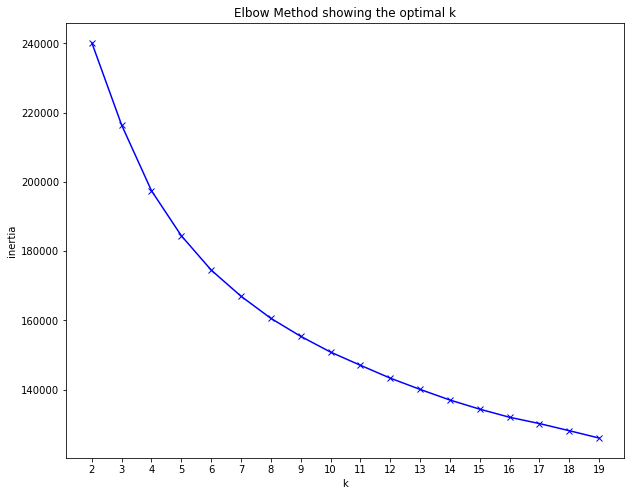

In [51]:

K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k)
                    
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [52]:
# i think the elbow point is 4. so my K is 4.

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

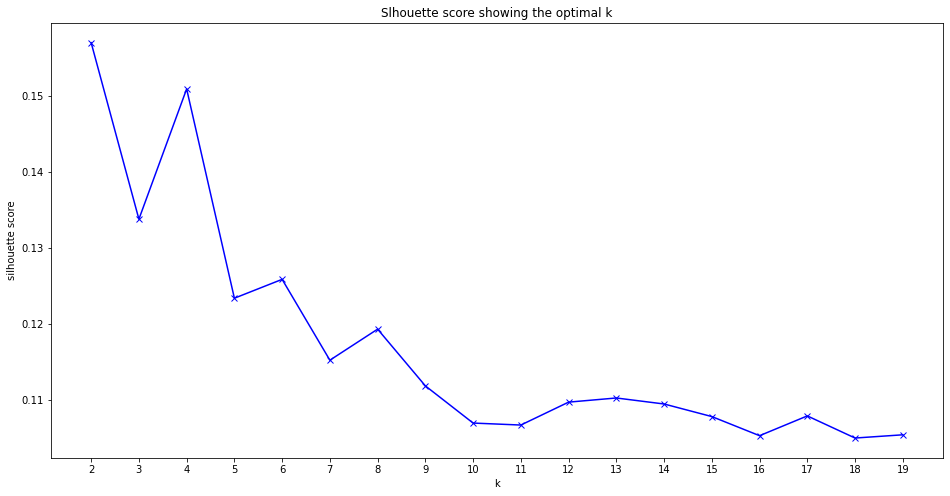

In [53]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

- By looking at the above silhoutte graph, we can confirm that 4 is a good number for K value

In [54]:
# By choosing a K value of 4 I have trained the KMeans model below

kmeans = KMeans(n_clusters=4)
kmeans.fit(X_prep)

KMeans(n_clusters=4)

In [55]:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0     4737
1    12259
2     2757
3     5396
dtype: int64

In [56]:
clusters

array([1, 1, 1, ..., 1, 1, 2], dtype=int32)

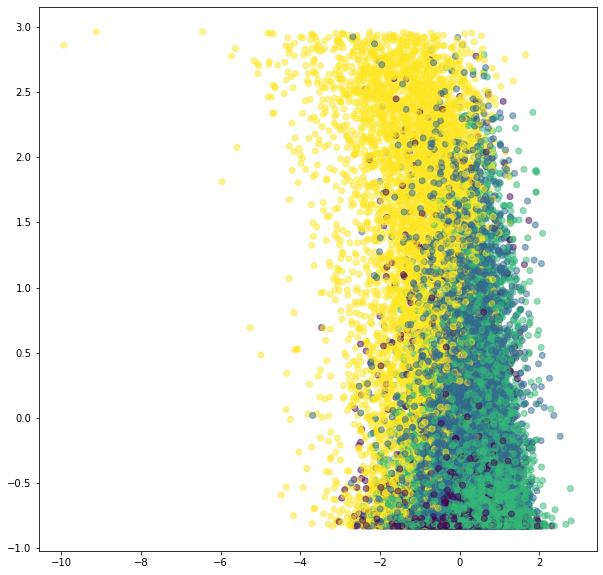

In [206]:
plt.figure(figsize=(10, 10))
plt.scatter(X_prep[:, 3], X_prep[:,5], c=clusters,alpha=0.5)
plt.show()

In [57]:
# Adding cluster information back to the original dataframe (before dropping the track name and artist name columns)
df_spotify['clusters'] = kmeans.labels_
df_spotify.head(10)

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,clusters
0,0.714,0.765,0,-9.380,0.0406,0.41000,0.508000,0.1190,0.9610,105.796,148440,1
1,0.655,0.878,3,-9.544,0.0312,0.83300,0.000402,0.0888,0.9360,129.957,188160,1
2,0.649,0.789,0,-9.466,0.0264,0.00441,0.000002,0.0859,0.9310,129.549,234333,1
3,0.644,0.785,8,-8.642,0.0284,0.00032,0.116000,0.0451,0.6680,116.938,293840,1
5,0.810,0.658,2,-9.676,0.0463,0.00348,0.922000,0.0744,0.7430,126.009,339524,2
6,0.385,0.975,6,-4.099,0.1920,0.00197,0.016700,0.0602,0.8210,204.397,170841,1
7,0.205,0.246,8,-16.175,0.0313,0.24500,0.602000,0.1110,0.0343,97.059,320960,3
8,0.756,0.803,2,-9.508,0.0956,0.42700,0.072400,0.0824,0.8780,136.568,163800,1
9,0.572,0.942,11,-3.660,0.0448,0.00280,0.055900,0.3500,0.8140,112.014,213813,1
10,0.712,0.680,1,-8.132,0.0966,0.13500,0.000000,0.6290,0.5270,99.074,243373,1


In [58]:
cluster_df = pd.merge(df, df_spotify)
print(cluster_df.shape)
cluster_df.sample(10)

(32103, 21)


,track_name,artist_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,clusters
12175,Trails of Smoke,Wode,spotify:track:1xdrHqUsNUhEdnXdjhfB0t,0.110,0.995,3,-5.441,1,0.1110,0.000061,...,0.3410,0.0368,158.536,audio_features,1xdrHqUsNUhEdnXdjhfB0t,https://api.spotify.com/v1/tracks/1xdrHqUsNUhE...,https://api.spotify.com/v1/audio-analysis/1xdr...,309640,4,2
674,La La La - Fatboy Slim Remix,Tranquility Bass,spotify:track:38WJrnUtKqpjpAYrqB6f4u,0.431,0.897,7,-7.448,1,0.1610,0.020000,...,0.7340,0.2710,191.531,audio_features,38WJrnUtKqpjpAYrqB6f4u,https://api.spotify.com/v1/tracks/38WJrnUtKqpj...,https://api.spotify.com/v1/audio-analysis/38WJ...,502747,4,1
6847,Baba O'Riley,The Who,spotify:track:3qiyyUfYe7CRYLucrPmulD,0.489,0.724,5,-8.367,1,0.0352,0.313000,...,0.2870,0.1500,117.292,audio_features,3qiyyUfYe7CRYLucrPmulD,https://api.spotify.com/v1/tracks/3qiyyUfYe7CR...,https://api.spotify.com/v1/audio-analysis/3qiy...,300400,4,1
24595,Your Peace (feat. Lil Baby),Jacquees,spotify:track:0AtY4uFaYBIl6tAjONkk1Z,0.518,0.630,6,-5.968,0,0.1990,0.009970,...,0.1010,0.5760,195.958,audio_features,0AtY4uFaYBIl6tAjONkk1Z,https://api.spotify.com/v1/tracks/0AtY4uFaYBIl...,https://api.spotify.com/v1/audio-analysis/0AtY...,183920,4,1
25549,Family Matters (feat. Arin Ray),Arin Ray,spotify:track:6dp8BFpvGV7DdwxyDYL5y7,0.492,0.536,7,-9.932,1,0.3820,0.251000,...,0.1950,0.3810,84.947,audio_features,6dp8BFpvGV7DdwxyDYL5y7,https://api.spotify.com/v1/tracks/6dp8BFpvGV7D...,https://api.spotify.com/v1/audio-analysis/6dp8...,210779,4,0
21085,"Memories Back Then (feat. B.o.B, Kendrick Lama...",B.o.B,spotify:track:0A2lJqfi04TKDTJYoKBxa9,0.796,0.504,2,-10.989,0,0.0524,0.115000,...,0.1360,0.2210,130.010,audio_features,0A2lJqfi04TKDTJYoKBxa9,https://api.spotify.com/v1/tracks/0A2lJqfi04TK...,https://api.spotify.com/v1/audio-analysis/0A2l...,304320,4,3
19193,Amazing,Jeezy,spotify:track:0m3Ze0cy8qBHSsV2exAfCw,0.588,0.554,8,-8.406,1,0.0545,0.216000,...,0.0619,0.4960,146.133,audio_features,0m3Ze0cy8qBHSsV2exAfCw,https://api.spotify.com/v1/tracks/0m3Ze0cy8qBH...,https://api.spotify.com/v1/audio-analysis/0m3Z...,238333,4,1
26278,Under The Weather,Mac Miller,spotify:track:15NEIBMCFHg6UElFbxQuph,0.715,0.794,10,-5.426,1,0.1630,0.132000,...,0.3610,0.6060,119.994,audio_features,15NEIBMCFHg6UElFbxQuph,https://api.spotify.com/v1/tracks/15NEIBMCFHg6...,https://api.spotify.com/v1/audio-analysis/15NE...,260974,4,1
30742,Affinity - Menno de Jong Remix,Menno de Jong,spotify:track:3hIGl7DagX5htIoe1Tb66t,0.543,0.818,5,-10.853,1,0.0391,0.001970,...,0.2030,0.5170,138.031,audio_features,3hIGl7DagX5htIoe1Tb66t,https://api.spotify.com/v1/tracks/3hIGl7DagX5h...,https://api.spotify.com/v1/audio-analysis/3hIG...,490434,4,2
28894,Camera,FKi 1st,spotify:track:3sQ6KL5clLt1gHSVM9VGRb,0.522,0.483,5,-7.622,0,0.3030,0.109000,...,0.1160,0.3040,100.132,audio_features,3sQ6KL5clLt1gHSVM9VGRb,https://api.spotify.com/v1/tracks/3sQ6KL5clLt1...,https://api.spotify.com/v1/audio-analysis/3sQ6...,328347,4,0


In [59]:
# Reusable functions

# Will provide the track uri for a track name
def get_track_uri(track_name):
    results = sp.search(q='track:' + track_name, type='track')
    if not results['tracks']['items']:
        raise ValueError('No song found!')
    return results['tracks']['items'][0]['uri']


def get_audio_features_df(track_uri):
    results = sp.audio_features(track_uri)
    audio_features_df = pd.DataFrame(results)
    audio_features_df = audio_features_df.drop(["uri","type","id","track_href","analysis_url", "mode", "time_signature"], axis = 1)
    return audio_features_df

def standardize_scale(scaler, df):
    return scaler.transform(df)
    
# get_audio_features_df(get_track_uri('Bull in the heather'))

def predict_cluster(track_name):
    track_uri = get_track_uri(track_name)
    audio_feature_df = get_audio_features_df(track_uri)
    scaled_df = standardize_scale(std_scaler, audio_feature_df)
    return kmeans.predict(scaled_df)[0]

def get_similar_track(df, track_name):
    c = predict_cluster(track_name)
    return df[df['clusters'] == c].sample(1).iloc[0]['track_name']

#get_track_uri('djljjldjldjfhfhgeeeye')
# get_similar_track(cluster_df, 'Bull in the heather')

## Billboard hot 100 songs

In [62]:
url = "https://www.billboard.com/charts/hot-100/"

In [64]:
response = requests.get(url)
response.status_code 

200

In [65]:
soup = BeautifulSoup(response.content, "html.parser")

In [66]:
song_singers = soup.select("ul.lrv-a-unstyle-list > li.o-chart-results-list__item.lrv-u-flex-grow-1.lrv-u-flex.lrv-u-flex-direction-column.lrv-u-justify-content-center.lrv-u-border-b-1.lrv-u-border-color-grey-light.lrv-u-padding-l-050")
#print(song_singers)

In [67]:
titles = []
singers = []
for i in song_singers:
    titles.append(i.select("h3#title-of-a-story")[0].get_text().strip()) # #- for accessing ID attribute.
    singers.append(i.select("span.c-label")[0].get_text().strip())
    
hot_100_df = pd.DataFrame({'song_title': titles, 'artists': singers})
print(hot_100_df.shape)
display(hot_100_df.sample(10))

(99, 2)


,song_title,artists
78,Put It On Me,YoungBoy Never Broke Again
47,Efecto,Bad Bunny
68,La Bachata,Manuel Turizo
44,Free Mind,Tems
84,Out In The Middle,Zac Brown Band
26,Glimpse Of Us,Joji
4,I Ain't Worried,OneRepublic
53,2 Be Loved (Am I Ready),Lizzo
35,Die For You,The Weeknd
97,What He Didn't Do,Carly Pearce


In [68]:
def song_recommender():
    a = input("Enter your favorite song: ")
# here i changed the user input to lower case because end user can give the input in any case.
# also i want to give the recommendation for the user atleast one word matches.
# so i used inline looping.
    
    if((any(a.lower() in title for title in hot_100_df['song_title'].str.lower().values))):

        ran_num = random.choice(hot_100_df['song_title'])
        print('Here you go ... We recommend this song for you \n ENJOY listening to the song:',ran_num)
    else:
        try:
            rec_song = get_similar_track(cluster_df, a.lower())
            print('Here is a similar song we recommend: ' + rec_song)
            print('ENJOY listening to the song!')
        except ValueError:
            print("Sorry, your song is not on the list and we don't have recommendations")
            repeat=input("Do you want to try another song? y/n")
            if repeat.lower() == 'y':
                song_recommender()
            else:
                print("Thank you for using our song recommender!")


In [72]:
song_recommender()

Enter your favorite song: Emlékszem
Here is a similar song we recommend: Anticipation
ENJOY listening to the song!
